In [1]:
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras import layers

In [2]:
DIR = '/content/drive/MyDrive/dog-breeds'

In [3]:
files = os.listdir(DIR)
print(files)
class_count = len(files)
print(f'There are {class_count} car model classes.')

['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']
There are 8 car model classes.


In [4]:
# Remove Non JPG images
for cls in files:
    cls_path = os.path.join(DIR, cls)
    imgs =  os.listdir(cls_path)
    img = Image.open(os.path.join(cls_path,imgs[0]))
    print(f'Class {cls} contains {len(imgs)} images images of shape {img.size}.')
    for filees in imgs:
        if filees.endswith(('.jpg', '.jpeg')):
            None
        else:
            os.remove(os.path.join(cls_path,filees))
    print(f'Class {cls} contains {len(os.listdir(cls_path))} images of shape {img.size}.')

Class beagle contains 83 images images of shape (509, 339).
Class beagle contains 83 images of shape (509, 339).
Class bulldog contains 76 images images of shape (359, 479).
Class bulldog contains 76 images of shape (359, 479).
Class dalmatian contains 51 images images of shape (1000, 625).
Class dalmatian contains 51 images of shape (1000, 625).
Class german-shepherd contains 76 images images of shape (1000, 1500).
Class german-shepherd contains 76 images of shape (1000, 1500).
Class husky contains 71 images images of shape (509, 339).
Class husky contains 71 images of shape (509, 339).
Class labrador-retriever contains 50 images images of shape (1000, 1500).
Class labrador-retriever contains 50 images of shape (1000, 1500).
Class poodle contains 56 images images of shape (1000, 1548).
Class poodle contains 56 images of shape (1000, 1548).
Class rottweiler contains 78 images images of shape (509, 339).
Class rottweiler contains 78 images of shape (509, 339).


Creating the data generator using ImageDataGenerator for the CNN

In [5]:
def train_val_generators():
    """
    Creates the training and validation data generators
    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images
    Returns:
        train_generator, validation_generator: tuple containing the generators
    """
    # Instantiate the ImageDataGenerator class, normalize pixel values and set arguments to augment the images
    datagen = ImageDataGenerator(rescale=1.0/255.0,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 fill_mode='nearest',
                                 horizontal_flip = True,
                                 validation_split=0.2)
    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = datagen.flow_from_directory(directory=DIR,
                                                        batch_size=64,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        subset='training',
                                                        target_size=(224,224))

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = datagen.flow_from_directory(directory=DIR,
                                                                  batch_size=32,
                                                                  class_mode='categorical',
                                                                  shuffle = False,
                                                                  subset='validation',
                                                                  target_size=(224, 224))
    return train_generator, validation_generator

In [6]:
train_generator, validation_generator = train_val_generators()

Found 435 images belonging to 8 classes.
Found 106 images belonging to 8 classes.


Define and compile the transfer learning model

In [7]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [8]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [9]:
# Choose `top_activation` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (class_count, activation='softmax')(x)

# Append the dense network to the base model
model_transfer = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [11]:
model_transfer.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Creating a Callback class

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.99):
            print(logs.get('val_accuracy'))
            print("\nReached 99% validation accuracy so cancelling training!")
callbacks = myCallback()

In [16]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=2,
    min_lr=0.00001,
    verbose=2
)

In [19]:
checkpoint_path = "/content/drive/MyDrive/dog-breeds"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                 monitor="val_accuracy",
                                                 save_best_only=True)

In [14]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

Train the model

In [20]:
history1 = model_transfer.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[callbacks, reduce_lr, cp_callback, early_stopping]
                   )

Epoch 1/15
7/7 [==============================] - 17s 3s/step - loss: 2.5945 - accuracy: 0.9356 - val_loss: 5.6833 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 2/15
7/7 [==============================] - 18s 3s/step - loss: 1.2737 - accuracy: 0.9586 - val_loss: 2.3004 - val_accuracy: 0.9151 - lr: 0.0010
Epoch 3/15
7/7 [==============================] - 17s 3s/step - loss: 0.4042 - accuracy: 0.9747 - val_loss: 2.3637 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 4/15
7/7 [==============================] - ETA: 0s - loss: 0.5301 - accuracy: 0.9747
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
7/7 [==============================] - 16s 2s/step - loss: 0.5301 - accuracy: 0.9747 - val_loss: 3.8945 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 5/15
7/7 [==============================] - 15s 2s/step - loss: 0.2298 - accuracy: 0.9839 - val_loss: 6.2192 - val_accuracy: 0.9151 - lr: 2.5000e-04
Epoch 6/15
7/7 [==============================] - 17s 3s/step - loss: 0.5327 - accur

In [21]:
print("Accuracy of the transfer_learning model is - " , model_transfer.evaluate(validation_generator)[1]*100 , "%")

4/4 [==============================] - 2s 492ms/step - loss: 2.5539 - accuracy: 0.9434
Accuracy of the transfer_learning model is -  94.33962106704712 %


Evaluating Accuracy and Loss for the Model

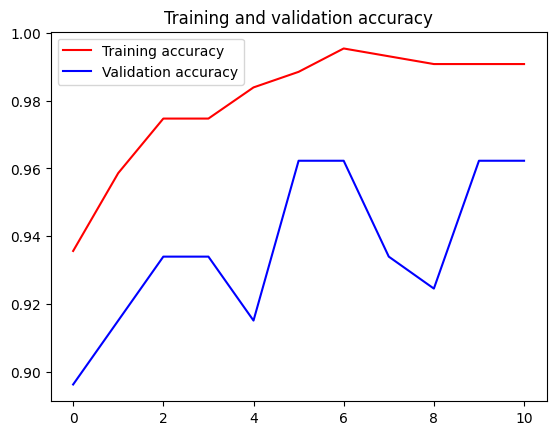

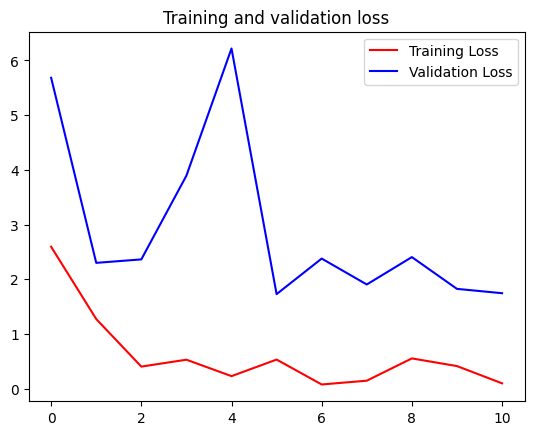

In [22]:
# Plot the chart for accuracy and loss on both training and validation
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
predictions = model_transfer.predict(validation_generator)
predictions=np.argmax(predictions,axis=-1)
print(predictions[:10])
print(validation_generator.labels[:10])

4/4 [==============================] - 4s 518ms/step
[0 0 0 0 0 0 5 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [24]:
dict_cls = validation_generator.class_indices

Plotting the Confusion Matrix for the Classification

<Axes: >

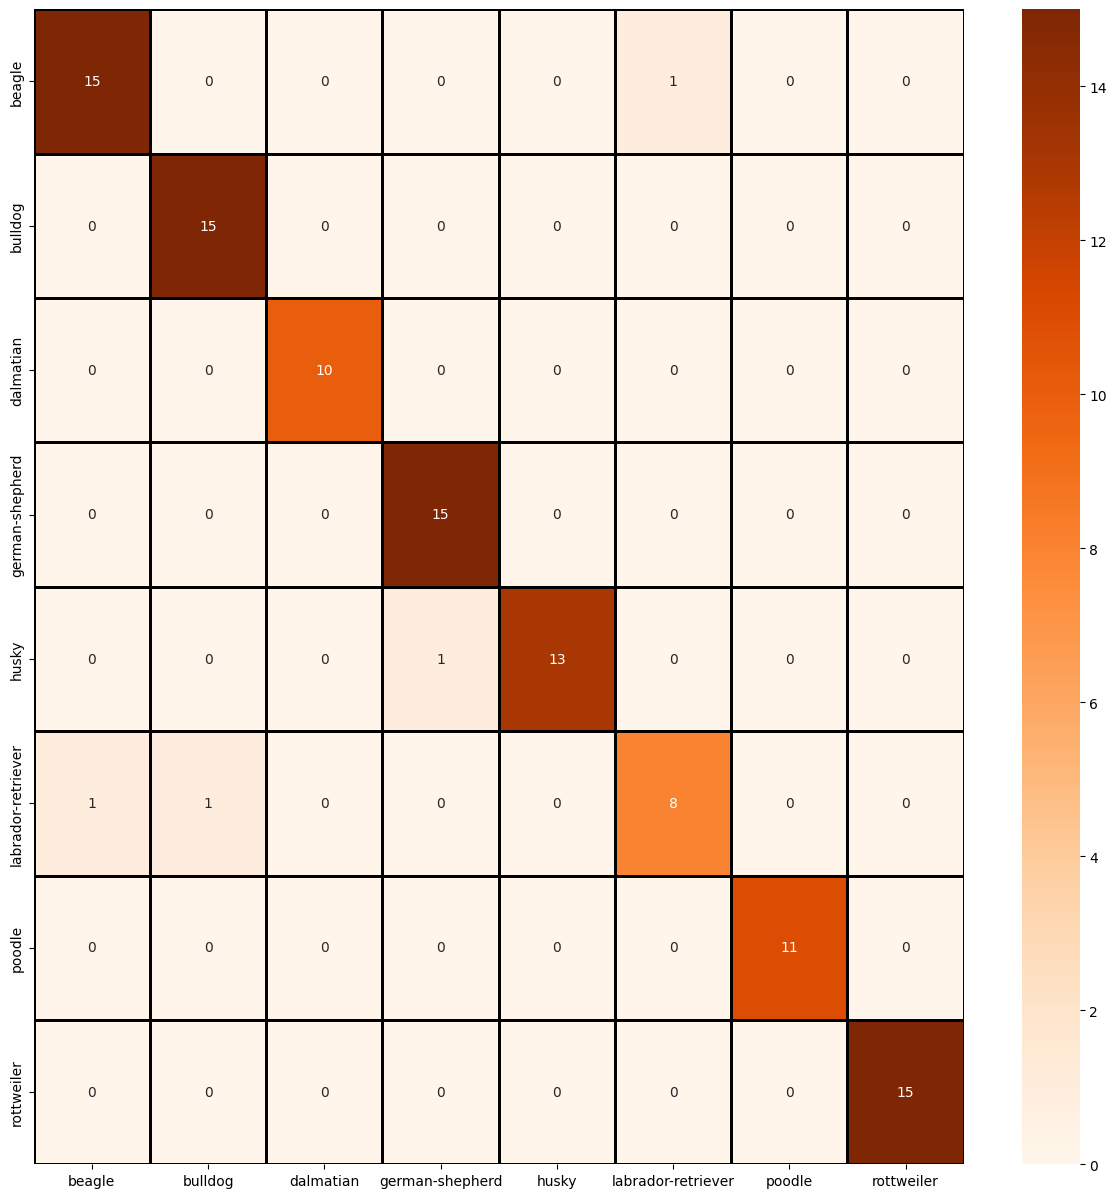

In [25]:
cm = confusion_matrix(validation_generator.labels,predictions)
cm = pd.DataFrame(cm , index = list(dict_cls.keys()) , columns = list(dict_cls.keys()))
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

Sample Model Prediction

In [26]:
def class_name(id):
    key_list = list(dict_cls.keys())
    val_list = list(dict_cls.values())
    position = val_list.index(id)
    return key_list[position]

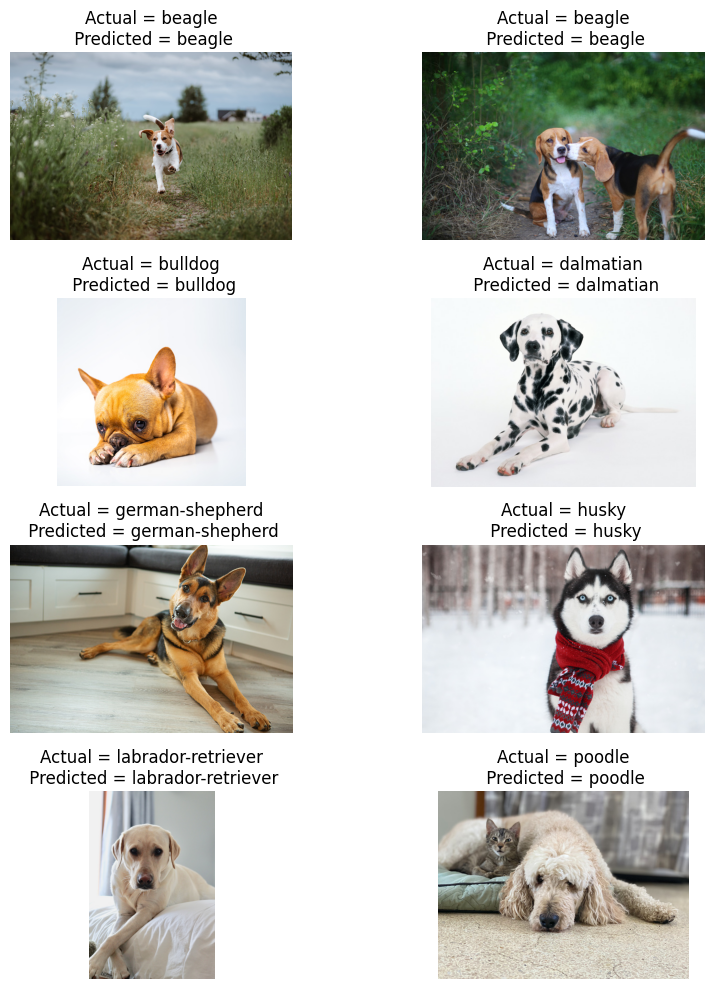

In [27]:
f, ax = plt.subplots(4,2)
f.set_size_inches(10, 10)
k = 1
for i in range(4):
    for j in range(2):
        true_cls = validation_generator.labels[k]
        true_cls = class_name(true_cls)
        pred_cls = predictions[k]
        pred_cls = class_name(pred_cls)
        ax[i,j].set_title(f'Actual = {true_cls}\n Predicted = {pred_cls}')
        path = DIR + '/' + validation_generator.filenames[k]
        img=plt.imread(path)
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        k += 12

    plt.tight_layout()

In [32]:
model_transfer.save('dogBreedNew.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


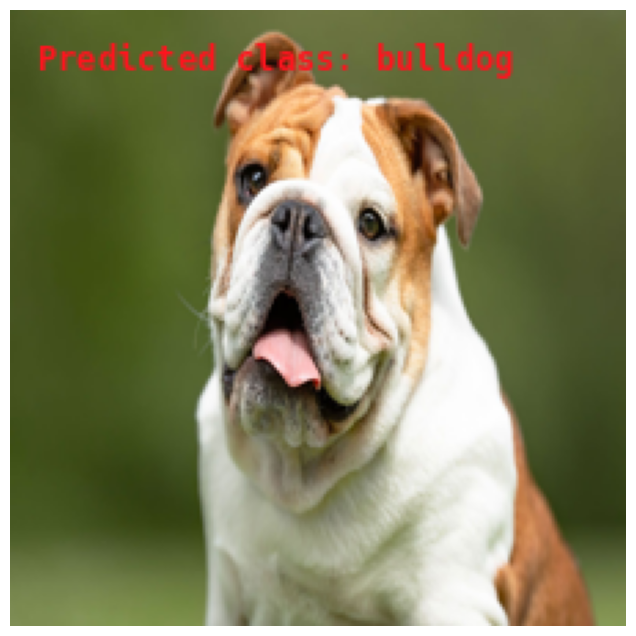

In [37]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import tensorflow as tf

# Define the URL of the image
image_url = "https://cdn.britannica.com/07/234207-050-0037B589/English-bulldog-dog.jpg"

# Load the image from the URL
response = requests.get(image_url)
image_path = Image.open(BytesIO(response.content))
image_resized_rgb = image_path.resize((224, 224)).convert('RGB')
image_array_rgb = np.array(image_resized_rgb)
image_scale_rgb = image_array_rgb.astype("float32") / 255.0
image_reshape_rgb = image_scale_rgb.reshape(1, 224, 224, 3)

# Load the pre-trained model (you should have the model loaded before running this code)
# Replace 'model' with the name of your loaded model
# Example: model = tf.keras.models.load_model('your_model.h5')
# Ensure that the model is compatible with the image size and preprocessing used here
model = tf.keras.models.load_model('/content/drive/MyDrive/dogBreedNew.h5')

# Make predictions
final_pred = model.predict(image_reshape_rgb)[0]
max_prob = np.argmax(final_pred)

# Define class labels (you should replace this with your own class labels)
# Example: class_labels = ['class1', 'class2', ...]
class_labels = ['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']

# Get the predicted class label
my_predict = class_labels[max_prob]

# Load a custom font (replace with the path to your own font file)
# Example: myFont = ImageFont.truetype('your_font.ttf', 12)
myFont = ImageFont.truetype('/content/drive/MyDrive/Hack-Bold.ttf', 12)

# Draw the predicted class label on the image
image_draw = ImageDraw.Draw(image_resized_rgb)
image_draw.text((10, 10), f"Predicted class: {my_predict}", font=myFont, fill=(255, 20, 30))

# Save the image with the prediction text
image_resized_rgb.save("my_image.png")

# Display the image with the prediction
plt.figure(figsize=(8, 8))
plt.imshow(image_resized_rgb)
plt.axis("off")
plt.show()